### Projeto para Detecção de vendedores que podem sair da base da Olist.

Com base na ABT criada através dos dados da Olist, estarei modelando um algoritmo para com o intuito de separar os vendores com base na probabilidade de não realizar vendas. 
para mais detahes verificar o Github Pages  **inserir o link**

In [1]:
#Importando bibliotecas
import os 
import sqlalchemy
from sqlalchemy.sql.elements import Label, collate
import numpy as np
import pandas as pd
from pandas.core.arrays import categorical
from pandas.io.formats.format import TextAdjustment
from pandas.io.pickle import read_pickle
from scipy import sparse

# Visualização
import sweetviz as sv
from sweetviz import feature_config
import matplotlib.pyplot as plt
import seaborn as sns

# Criaçao de Pipeline
from sklearn import pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Pre processamento
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Metodos e Modelos 
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate, RandomizedSearchCV, GridSearchCV

# Algormitmos de ML
from sklearn import tree, ensemble, svm, neighbors, linear_model, naive_bayes
import lightgbm as lgb

# Métricas
from sklearn.metrics import roc_curve , classification_report, roc_auc_score

# Outras Configurações
pd.set_option('display.max_columns',100)

## Carregando a ABT

A ABT se encontra na tabela **tb_abt_no_sells**

In [2]:
# Carregando os paths do banco de dados
dir_local = os.path.dirname(os.path.abspath('__file__'))
dir_project = os.path.dirname(dir_local)
dir_db = os.path.join(dir_project,'Data/olist.db')
# Efetuando a conexão com o SQLAlchemy e carregando o Dataset
con = sqlalchemy.create_engine('sqlite:///'+ dir_db)
load_abt_churn = "SELECT * from tb_abt_no_sells"
dataset = pd.read_sql(load_abt_churn , con)

## Conhecendo o Dataset

A ABT possui 22 Variáveis Quantitativas sendo 13 Continuas e 9 Discretas (incluindo a variável alvo) e 3 Variáveis Qualitativas sendo as 3 Nominais.  
Existem 2 variáveis que possuem dados nulos que deverão ser tratadas posteriormente

In [3]:
dataset.head()

,flag_venda,data_lim_safra,seller_id,estado,idade_dias,qtde_vendas,variedade_prod,qtde_prod_vendidos,media_prod_vend_order,media_fotos,media_letras_desc,avaliacao_safra,avaliacao_acumulada,delta_avaliacao_idade_base,ultima_venda,qtde_mes_ativos,prop_atrasos,media_prazo_entrega,receita_total,ticket_medio,valor_medio_prod,total_mensal,frete_medio,prop_valor_frete,intervalo_pedidos_dias
0,1,2017-04-01,001cca7ae9ae17fb1caed9dfb1094831,ES,55,16,3,28,1.750000,2.928571,497.642857,3.571429,3.571429,-0.0,0,2,0.035714,26,2775.60,173.47500,99.128571,1387.800000,40.237500,0.231950,3
1,1,2017-04-01,004c9cd9d87a3c30c522c48c4fc07416,SP,62,23,23,30,1.304348,1.206897,628.413793,4.533333,4.533333,-0.0,11,3,0.033333,27,3818.21,166.00913,127.273667,1272.736667,22.273043,0.134168,2
2,0,2017-04-01,00ab3eff1b5192e5f1a63bcecfee11c8,SP,13,1,1,1,1.000000,1.000000,646.000000,5.000000,5.000000,0.0,13,1,0.000000,18,98.00,98.00000,98.000000,98.000000,12.080000,0.123265,13
3,0,2017-04-01,011b0eaba87386a2ae96a7d32bb531d1,SP,175,1,1,2,2.000000,1.000000,1212.000000,4.000000,4.000000,0.0,175,1,0.000000,53,99.98,99.98000,49.990000,99.980000,29.180000,0.291858,175
4,0,2017-04-01,013900e863eace745d3ec7614cab5b1a,PR,27,2,2,2,1.000000,5.500000,883.000000,5.000000,5.000000,0.0,4,1,0.000000,27,146.00,73.00000,73.000000,146.000000,20.160000,0.276164,13


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17015 entries, 0 to 17014
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   flag_venda                  17015 non-null  object 
 1   data_lim_safra              17015 non-null  object 
 2   seller_id                   17015 non-null  object 
 3   estado                      17015 non-null  object 
 4   idade_dias                  17015 non-null  int64  
 5   qtde_vendas                 17015 non-null  int64  
 6   variedade_prod              17015 non-null  int64  
 7   qtde_prod_vendidos          17015 non-null  int64  
 8   media_prod_vend_order       17015 non-null  float64
 9   media_fotos                 16595 non-null  float64
 10  media_letras_desc           16595 non-null  float64
 11  avaliacao_safra             17015 non-null  float64
 12  avaliacao_acumulada         17015 non-null  float64
 13  delta_avaliacao_idade_base  170

## Separando uma parte do dataset para Out of Time (OOT)
Nesse caso será separada a **última safra** para OOT as restantes serão utilizadas para o desenvolvimento do algoritmo.

In [5]:
safras = dataset['data_lim_safra'].unique()
safras_oot = safras[-1:] # Separando a data da última safra

dataset['flag_venda'] = dataset['flag_venda'].astype(int)
dataset['estado'] = dataset['estado'].astype('category')
df_oot = dataset[ dataset['data_lim_safra'] >= safras_oot[0]].copy() # dataset de validação
df = dataset[ dataset['data_lim_safra'] < safras_oot[0]].copy() # dataset para desenvolvimento

print(f"Safra separada para Tratamento : {df['data_lim_safra'].unique()}")
print(f"Safra separada para Out Of Time : {df_oot['data_lim_safra'].unique()}")


Safra separada para Tratamento : ['2017-04-01' '2017-05-01' '2017-06-01' '2017-07-01' '2017-08-01'
 '2017-09-01' '2017-10-01' '2017-11-01' '2017-12-01' '2018-01-01'
 '2018-02-01' '2018-03-01' '2018-04-01']
Safra separada para Out Of Time : ['2018-05-01']


## Manipulando e separando as Features para o início dos trabalhos

In [6]:
# Separando as colunas de features e target e separando os dados entre treino e teste
target = 'flag_venda'
df_columns = df.columns.to_list()
to_remove = ['flag_venda', 'data_lim_safra', 'seller_id']
features = [i for i in df_columns if i not in to_remove]

## Análise Exploratória dos dados

Para a análise dos dados estou utilizando o Sweet Viz como ferramenta e para verificar os gráficos o mesmo esta salvo como Analise Exploratória.html nesta mesma pasta
* Flag Venda = possui dados desbalanceado (69%/31%)  
* Data Limite Safra = Demonstra um crescimento na quantidade de vendas já que são apenas computadas as vendas que foram realmente efetivadas,  
* Estado = Demonstra uma predominancia dos vendedores residentes no estado de SP seguido do PR
* Idade Dias = Pode-se observar que a maioria dos usuários possui menos de 5 meses na plataforma
* Qtde de Vendas  = 21.1% deste dataset com vendedores com apenas uma venda, ***
* Variedade de Produtos = Mais de 50% do do dataset possui 3 produtos como variedade vendidas
* Ticket Médio = Verificando os valores altos de Ticket médio curiosamente localizei um potencial vendedor fraudador da plataforma onde possuia um Ticket médio alto mas péssimas avaliaçoes, resolvi ir um pouco a fundo e realmente parecia muito suspeito. Como não é o proposito deste projeto detectar fraudador e o mesmo irá fornecer dados não condizentes com a realidade de vendas, resolvi tirar estes dados do dataset
* Ao verificar a correlação das variáveis houve 3 casos de variaveis com uma alta correlação sendo assim resolvi excluir 2 variáveis Qtde de Vendas e Avaliação Acumulada, o ultimo caso resolvi manter ambas as variáveis (Ticket médio e Valor Médio do Produto), pois caso os clientes comprem diversas quantidades essa variável irá se alterar.


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)


Report Analise_Exploratoria.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


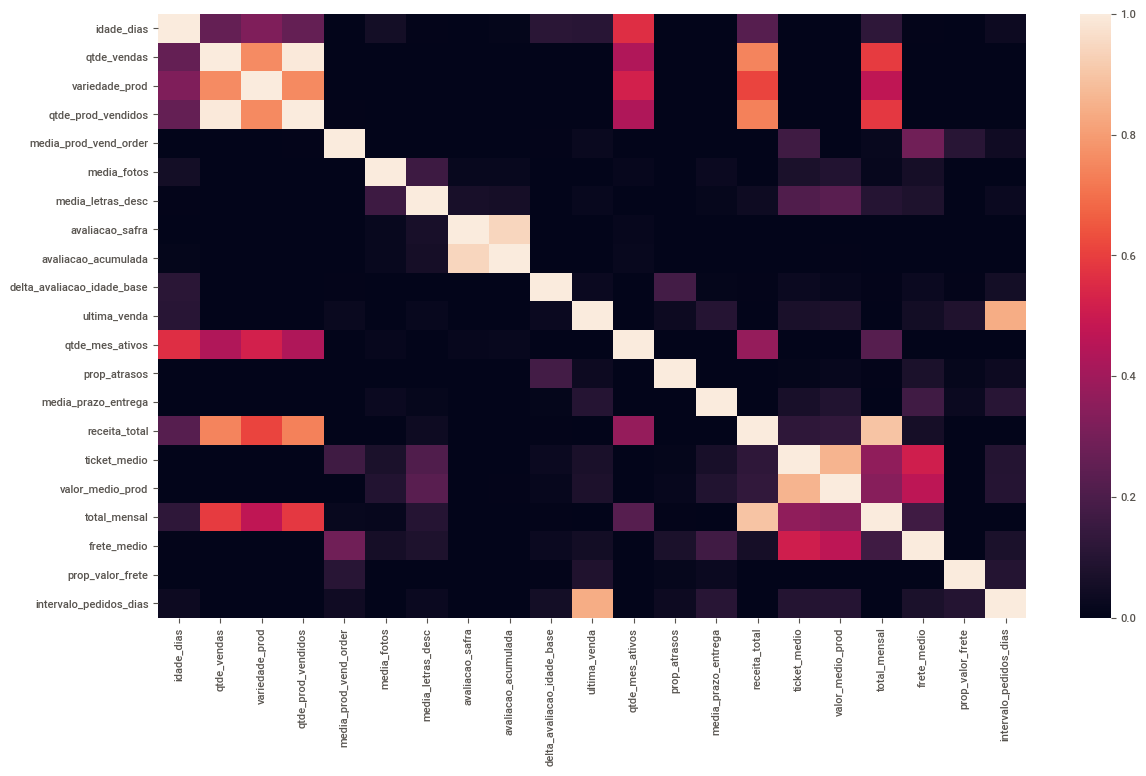

In [7]:
#Carregando o relatório através do SweetViz
#Em 2 colunas foram encontrados 2% do dataset com valores nulos Média de fotos e Média letras descrição.
# Distribuição destes dados se mostra Assimétrica Positiva e estarei substituindo estes valores pela mediana posteriormente.
report = sv.analyze(df)
report.show_html(filepath='Analise_Exploratoria.html')



# Sei que o SweetViz fornece tambem uma visualização correlação porém prefiro a do Seaborn
plt.figure(figsize = (14, 8))
correlation = df[features].corr(method = 'pearson')
ax = sns.heatmap(correlation, vmin=0, vmax=1)

In [446]:
# Retirando da base o Vendedor com grandes chances de ser um fraudador
sellers_fraude = df.query('ticket_medio>1500 and avaliacao_safra < 2')['seller_id'].unique().tolist() #Localizando o Vendedor que pode ser um fraudador
df = df.query('seller_id not in @sellers_fraude') # Retirando o possível usuário fraudador

# Variaveis com correlacoes altas
corr_alta = ['qtde_vendas','avaliacao_acumulada']
features = [i for i in features if i not in corr_alta] # Removendo as 2 variáveis

## Preparação e definição do Pipeline que realizará pré processamento

Definida a estratégia para reposição dos dados nulos, os dados irão ser separados em variaváveis numéricas e categóricas.
Existe apenas uma coluna com variaveis categoricas 'estado', como a mesma se trata de uma variável nominal, portanto não há necessidade de realizar um tratamento de variaveis categoricas ordinais neste dataset.  
Para as variáveis numéricas será aplicado o Simple Imputer substituindo os valores pela mediana e posteriormente aplicando o MinMax Scaler para o pre-processamento.
Para as variáveis categóricas será aplicado o One Hot Encoder


In [447]:
# Separando as features entre categóricas e numéricas
cat_features = df[features].dtypes[df[features].dtypes == 'category'].index.tolist()
num_features = df[features].dtypes[df[features].dtypes !='category'].index.tolist()

num_enc = Pipeline([('imputer' , SimpleImputer(missing_values= np.nan , strategy='median')),
                    ('scaler', MinMaxScaler())])
preparation = ColumnTransformer( transformers= [    ('numeric', num_enc, num_features),
                                                    ('categorical' , OneHotEncoder(handle_unknown = 'ignore'), cat_features)])

## Validação Cruzada

### Validação Cruzada com os Algoritmos a serem usados nas Pipelines
Selecionando alguns algoritmos para verificar os resultados de cada um deles. Estarei utilizando a métricas de ROC AUC Score como base neste Validação cruzada.  
OBS1: Como alguns algoritmos apresentaram overfit já apliquei algumas medidas para evitar o overfit das mesmas.  
OBS2: Como são testados diversos algoritmos ao mesmo tempo nesta etapa estarei aplicando o mesmo pipeline de preparacao dos dados, compreendo que alguns não necessitam de certos pre processamentos porém é apenas uma baseline para a escolha do algoritmo.

In [448]:
#Definição dos Algoritmos de Machine Learning
algoritmos = [ 
                # Tree
                tree.DecisionTreeClassifier(min_samples_leaf = 0.01 ),
                tree.ExtraTreeClassifier(min_samples_leaf = 0.01),
                # SVM
                svm.LinearSVC(),
                # Neighbors
                neighbors.KNeighborsClassifier(n_neighbors = 7),
                # Naive Bayes
                naive_bayes.BernoulliNB(),
                naive_bayes.GaussianNB(),
                # GLM
                linear_model.LogisticRegression(),
                linear_model.RidgeClassifier(),
                linear_model.SGDClassifier(),
                linear_model.Perceptron(),
                # Ensemble Methods
                ensemble.AdaBoostClassifier(),
                ensemble.GradientBoostingClassifier(),
                ensemble.ExtraTreesClassifier(min_samples_leaf = 0.01),
                ensemble.RandomForestClassifier(min_samples_leaf = 0.01),
                lgb.LGBMClassifier(is_unbalance=True)
                ]

#Criando um Dataframe com os resultados assim pode-se comparar os resultados

MLA_cols = ["MLA Name", "MLA Parameters", "MLA Train ROC_AUC Mean", "MLA Test ROC_AUC Mean", "MLA Test ROC_AUC DV Pad", "MLA Time"]
MLA_Compare = pd.DataFrame(columns=MLA_cols)
row_index = 0 # set index

# A métrica utilizada para escolha do melhor algoritmo será a ROC AUC

cv_split = ShuffleSplit(random_state=123)
for algoritmo in algoritmos:
    pipe_loop = Pipeline([  ('prep' , preparation),
                            ('alg' , algoritmo)])
    MLA_name = pipe_loop['alg'].__class__.__name__  
    print(f"Processando o algoritmo {MLA_name}") 
    MLA_Compare.loc[row_index,"MLA Name"]  = MLA_name
    MLA_Compare.loc[row_index, "MLA Parameters"] = str(pipe_loop['alg'].get_params())
    cv_results = cross_validate(pipe_loop, X= df[features], y= df[target], cv= cv_split, return_train_score=True, n_jobs=-1 , scoring='roc_auc')
    #Resultados da validação cruzada
    MLA_Compare.loc[row_index, "MLA Time"] = cv_results['fit_time'].mean()
    MLA_Compare.loc[row_index, "MLA Train ROC_AUC Mean"] = cv_results['train_score'].mean()
    MLA_Compare.loc[row_index, "MLA Test ROC_AUC Mean"] = cv_results['test_score'].mean()
    MLA_Compare.loc[row_index, "MLA Test ROC_AUC DV Pad"] = cv_results['test_score'].std()*3
    row_index +=1

MLA_Compare.sort_values(by="MLA Test ROC_AUC Mean", ascending=False, inplace=True , ignore_index=True)

Processando o algoritmo DecisionTreeClassifier
Processando o algoritmo ExtraTreeClassifier
Processando o algoritmo LinearSVC
Processando o algoritmo KNeighborsClassifier
Processando o algoritmo BernoulliNB
Processando o algoritmo GaussianNB
Processando o algoritmo LogisticRegression
Processando o algoritmo RidgeClassifier
Processando o algoritmo SGDClassifier
Processando o algoritmo Perceptron
Processando o algoritmo AdaBoostClassifier
Processando o algoritmo GradientBoostingClassifier
Processando o algoritmo ExtraTreesClassifier
Processando o algoritmo RandomForestClassifier
Processando o algoritmo LGBMClassifier


### Resultados da Validação Cruzada
Como esperado os melhores resultados vieram de algoritmos ensembles, o algoritmo de **Light GBM** como padrão utiliza o metodo de Gradient Boosting Decision Trees com algumas diferenças do Gradient Boosting em outros parametros.
Como o tempo de processamento para otimizar os parametros do Light GBM é relativamente mais rápido e os resultados em uma baseline foram melhores, estarei utilizando ele para as proximas etapas.

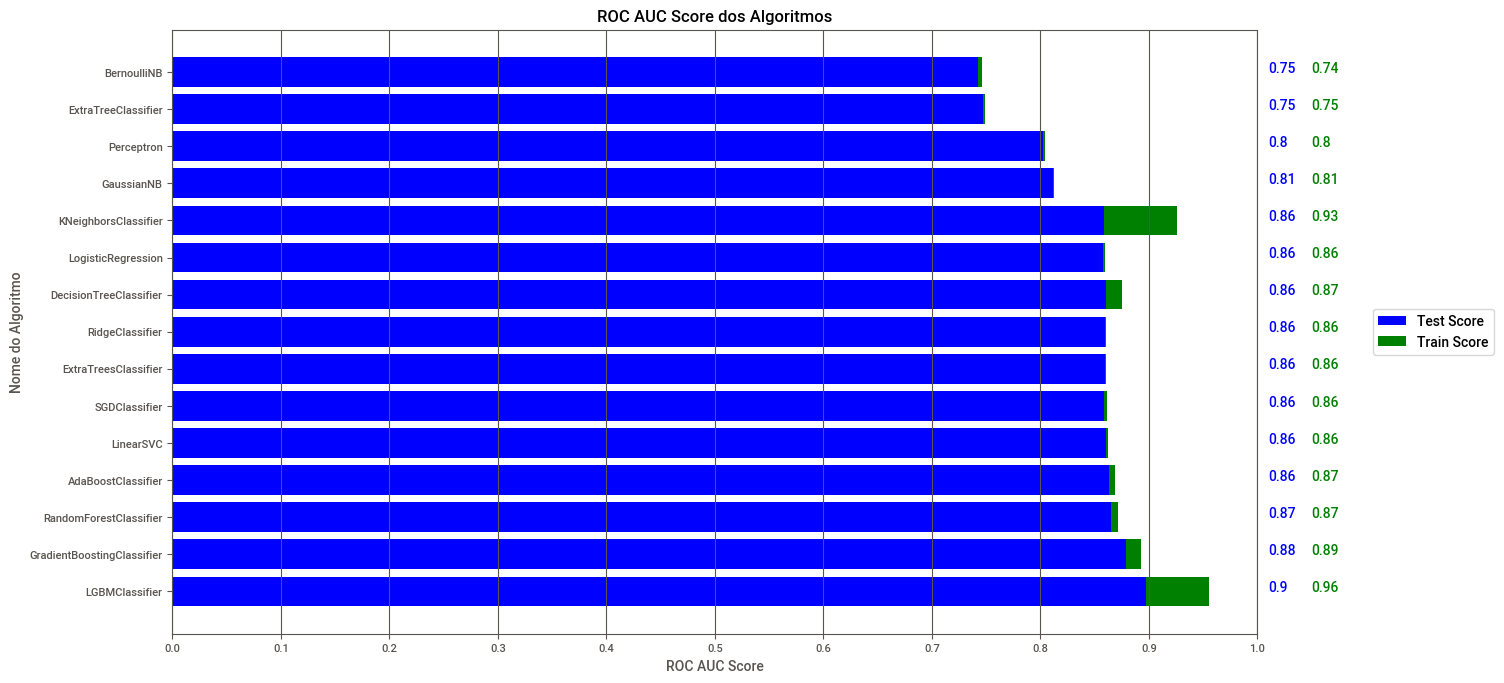

In [449]:
fig, ax = plt.subplots(figsize = (14, 8))
ax.barh(y=MLA_Compare['MLA Name'], width=MLA_Compare['MLA Test ROC_AUC Mean'], color = 'b' , label = 'Test Score')
ax.barh(y=MLA_Compare['MLA Name'], width=MLA_Compare['MLA Train ROC_AUC Mean']- MLA_Compare['MLA Test ROC_AUC Mean'], color = 'g', label = "Train Score", left=MLA_Compare['MLA Test ROC_AUC Mean'] )
for index, data in enumerate(MLA_Compare['MLA Test ROC_AUC Mean']):
    plt.text(x=1.01 , y = index, s=MLA_Compare['MLA Test ROC_AUC Mean'][index].round(2) ,color = "b")
    plt.text(x=1.05 , y = index, s=MLA_Compare['MLA Train ROC_AUC Mean'][index].round(2), color = "g")
plt.xlim(0,1)
ax.grid(axis="x")
plt.ylabel("Nome do Algoritmo")
plt.xlabel("ROC AUC Score")
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.title('ROC AUC Score dos Algoritmos')
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.show()

## Separando a variável resposta e dividindo entre treino e teste
Será utilizado 25% dos dados para teste e 75% para treino

In [450]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], stratify= df[target], random_state= 200)

## Verificando as métricas do algoritmo mais a fundo
#### Os 3 primeiros Algoritmos serão descartados, foram realizados no inicio do projeto estes haviam fornecido melhores resultados que acabaram sendo superados.
#### Apenas deixei os mesmos para demonstrar a evolução dos resultados obtidas
#### Caso deseje ir direto ao utilizado ir diretamente para o Light GBM

### Funções para auxiliar a visualização dos dados

In [451]:
# functions para auxiliar a visualização dos resultados.

def report(y_true, X, pipe, titulo= None):
    y_pred = pipe.predict(X)
    print(titulo)
    print(classification_report(y_true, y_pred, target_names = ['Não Vendeu', 'Vendeu']))

def plot_roc_curve(fpr, tpr, titulo = None):
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title("Curva ROC")
    plt.legend(title = "Base de dados", )
    plt.plot(fpr, tpr, label = titulo)
    plt.show()

### Extra Trees Classifier
#### Será descartado, no início ele havia apresentado os melhores resultados

Test Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.78      0.38      0.51      1191
      Vendeu       0.77      0.95      0.85      2618

    accuracy                           0.77      3809
   macro avg       0.77      0.67      0.68      3809
weighted avg       0.77      0.77      0.75      3809

OOT Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.83      0.45      0.59       604
      Vendeu       0.77      0.95      0.85      1177

    accuracy                           0.78      1781
   macro avg       0.80      0.70      0.72      1781
weighted avg       0.79      0.78      0.76      1781

ROC AUC SCORE:
AUC SCORE Test Dataset: 0.86
AUC SCORE OOT Dataset: 0.87


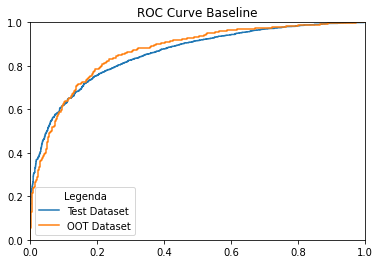

In [176]:
# Resultados com o Dataset de Testes e OOT
pipeline_Ex_tree = Pipeline([   ('prep' , preparation),
                                ('alg' , ensemble.ExtraTreesClassifier(max_iter=500, class_weight="balanced" ))])

pipeline_Ex_tree.fit(X_train[features], y_train)
# Dataset de Teste
report(y_test,X_test, pipeline_Ex_tree, "Test Dataset")
df_test_pred = pipeline_Ex_tree.predict(X_test)
df_test_pred_proba = pipeline_Ex_tree.predict_proba(X_test)[:,1]
fpr_test, tpr_test, _ = roc_curve(y_test, df_test_pred_proba, pos_label=1)

# OOT Dataset
report(df_oot[target],df_oot[features], pipeline_Ex_tree, "OOT Dataset")
df_oot_pred = pipeline_Ex_tree.predict(df_oot[features])
pred_oot_proba =  pipeline_Ex_tree.predict_proba(df_oot[features])[:,1]
fpr_oot, tpr_oot, thresh_opt = roc_curve(df_oot[target], pred_oot_proba, pos_label=1)

print("ROC AUC SCORE:")
print(f'AUC SCORE Test Dataset: {roc_auc_score(y_test,df_test_pred_proba ).round(2)}')
print(f'AUC SCORE OOT Dataset: {roc_auc_score(df_oot[target],pred_oot_proba ).round(2)}')

# Curva ROC com o Dataset de Teste e OOT
roc_test_df = plt.plot(fpr_test, tpr_test, label = "Test Dataset")
roc_oot_df = plt.plot(fpr_oot, tpr_oot, label = "OOT Dataset")
plt.title(label="ROC Curve Baseline")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(title = "Legenda")

### Logistic Regression
#### Será descartado, junto ao Extra Trees haviam fornecidos resultados semelhantes

Test Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.63      0.71      0.67      1191
      Vendeu       0.86      0.81      0.83      2618

    accuracy                           0.78      3809
   macro avg       0.75      0.76      0.75      3809
weighted avg       0.79      0.78      0.78      3809

OOT Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.71      0.75      0.73       604
      Vendeu       0.87      0.84      0.85      1177

    accuracy                           0.81      1781
   macro avg       0.79      0.79      0.79      1781
weighted avg       0.81      0.81      0.81      1781

ROC AUC SCORE:
AUC SCORE Test Dataset: 0.85
AUC SCORE OOT Dataset: 0.87


(0.0, 1.0)

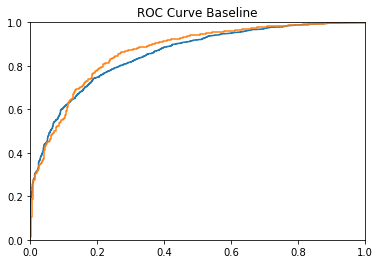

In [177]:
pipeline_log_regr = Pipeline([   ('prep' , preparation),
                                ('alg' , linear_model.LogisticRegression(max_iter=500, class_weight="balanced" ))])

pipeline_log_regr.fit(X_train[features], y_train)
# Resultados com o Dataset de Testes e OOT
# Dataset de Teste
report(y_test,X_test, pipeline_log_regr, "Test Dataset")
df_test_pred = pipeline_log_regr.predict(X_test)
df_test_pred_proba = pipeline_log_regr.predict_proba(X_test)[:,1]
fpr_test, tpr_test, _ = roc_curve(y_test, df_test_pred_proba, pos_label=1)

# OOT Dataset
report(df_oot[target],df_oot[features], pipeline_log_regr, "OOT Dataset")
df_oot_pred = pipeline_log_regr.predict(df_oot[features])
pred_oot_proba =  pipeline_log_regr.predict_proba(df_oot[features])[:,1]
fpr_oot, tpr_oot, thresh_opt = roc_curve(df_oot[target], pred_oot_proba, pos_label=1)

print("ROC AUC SCORE:")
print(f'AUC SCORE Test Dataset: {roc_auc_score(y_test,df_test_pred_proba ).round(2)}')
print(f'AUC SCORE OOT Dataset: {roc_auc_score(df_oot[target],pred_oot_proba ).round(2)}')

# Curva ROC com o Dataset de Teste e OOT
roc_test_df = plt.plot(fpr_test, tpr_test, label = "Test Dataset")
roc_oot_df = plt.plot(fpr_oot, tpr_oot, label = "OOT Dataset")
plt.title(label="ROC Curve Baseline")
plt.xlim(0,1)
plt.ylim(0,1)

### Gradient Boosting
#### Será descatado também

Test Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.71      0.62      0.66      1191
      Vendeu       0.84      0.88      0.86      2618

    accuracy                           0.80      3809
   macro avg       0.77      0.75      0.76      3809
weighted avg       0.80      0.80      0.80      3809

OOT Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.76      0.65      0.70       604
      Vendeu       0.83      0.90      0.86      1177

    accuracy                           0.81      1781
   macro avg       0.80      0.77      0.78      1781
weighted avg       0.81      0.81      0.81      1781

ROC AUC SCORE:
AUC SCORE Test Dataset: 0.87
AUC SCORE OOT Dataset: 0.88


(0.0, 1.0)

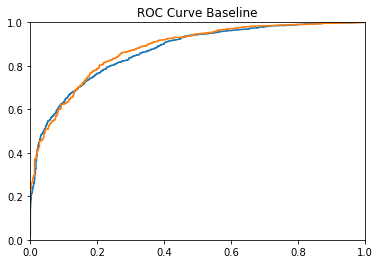

In [178]:
pipeline_grad_boosting = Pipeline([   ('prep' , preparation),
                                ('alg' , ensemble.GradientBoostingClassifier())])

pipeline_grad_boosting.fit(X_train[features], y_train)
# Resultados com o Dataset de Testes e OOT
# Dataset de Teste
report(y_test,X_test, pipeline_grad_boosting, "Test Dataset")
df_test_pred = pipeline_grad_boosting.predict(X_test)
df_test_pred_proba = pipeline_grad_boosting.predict_proba(X_test)[:,1]
fpr_test, tpr_test, _ = roc_curve(y_test, df_test_pred_proba, pos_label=1)

# OOT Dataset
report(df_oot[target],df_oot[features], pipeline_grad_boosting, "OOT Dataset")
df_oot_pred = pipeline_grad_boosting.predict(df_oot[features])
pred_oot_proba =  pipeline_grad_boosting.predict_proba(df_oot[features])[:,1]
fpr_oot, tpr_oot, thresh_opt = roc_curve(df_oot[target], pred_oot_proba, pos_label=1)

print("ROC AUC SCORE:")
print(f'AUC SCORE Test Dataset: {roc_auc_score(y_test,df_test_pred_proba ).round(2)}')
print(f'AUC SCORE OOT Dataset: {roc_auc_score(df_oot[target],pred_oot_proba ).round(2)}')

# Curva ROC com o Dataset de Teste e OOT
roc_test_df = plt.plot(fpr_test, tpr_test, label = "Test Dataset")
roc_oot_df = plt.plot(fpr_oot, tpr_oot, label = "OOT Dataset")
plt.title(label="ROC Curve Baseline")
plt.xlim(0,1)
plt.ylim(0,1)

### Light GBM
#### Como o LGBM possui um próprio método de lidar com Variáveis Categóricas retirei da Pipeline o One Hot Encoder

Test Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.66      0.81      0.73      1187
      Vendeu       0.90      0.81      0.85      2613

    accuracy                           0.81      3800
   macro avg       0.78      0.81      0.79      3800
weighted avg       0.83      0.81      0.81      3800

OOT Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.69      0.77      0.73       604
      Vendeu       0.88      0.82      0.85      1177

    accuracy                           0.80      1781
   macro avg       0.78      0.80      0.79      1781
weighted avg       0.81      0.80      0.81      1781

ROC AUC SCORE:
AUC SCORE Test Dataset: 0.9
AUC SCORE OOT Dataset: 0.88


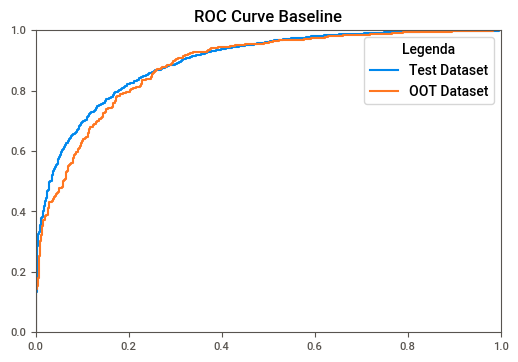

In [453]:
#Elaboração do Pipeline
preparation1 = ColumnTransformer( transformers=  [  ('numeric', num_enc, num_features)])
pipe_lgbm = Pipeline([  ('prep' , preparation1),
                        ('alg' , lgb.LGBMClassifier(is_unbalance =  True))])
pipe_lgbm.fit(X_train[features], y_train)

# Resultados com o Dataset de Testes e OOT
# Dataset de Teste
report(y_test,X_test[features], pipe_lgbm, "Test Dataset")
y_test_proba = pipe_lgbm.predict_proba(X_test)[:,1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba, pos_label=1)

#OOT Dataset
report(df_oot[target],df_oot[features], pipe_lgbm, "OOT Dataset")
y_oot_proba =  pipe_lgbm.predict_proba(df_oot[features])[:,1]
fpr_oot, tpr_oot, _ = roc_curve(df_oot[target], y_oot_proba, pos_label=1)

print("ROC AUC SCORE:")
print(f'AUC SCORE Test Dataset: {roc_auc_score(y_test,y_test_proba ).round(2)}')
print(f'AUC SCORE OOT Dataset: {roc_auc_score(df_oot[target],y_oot_proba ).round(2)}')

#Curva ROC com o Dataset de Teste e OOT
roc_test_df = plt.plot(fpr_test, tpr_test, label = "Test Dataset")
roc_oot_df = plt.plot(fpr_oot, tpr_oot, label = "OOT Dataset")
plt.title(label="ROC Curve Baseline")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(title = "Legenda")


## Otimizacão dos Hyperparametros
#### Os 3 primeiros Algoritmos serão descartados, foram realizados no inicio do projeto estes haviam fornecido melhores resultados que acabaram sendo superados
#### Apenas deixei os mesmos para demonstrar a evolução dos resultados obtidas
#### Caso deseje ir direto ao utilizado ir diretamente para o Light GBM

### Extra Trees Classifier

In [155]:
# Otimizando os parametros do algoritmo com Randomized Search
'''
min_samples = np.linspace(start=0.02, stop=0.05 )

grid = {    "alg__n_estimators" : [100,200,500,1000],
            "alg__criterion" : ['gini','entropy'],
            "alg__max_depth" : [5,10,15,20,25],
            "alg__min_samples_split" : min_samples,
            "alg__min_samples_leaf" : min_samples}


otimizacao_tree = RandomizedSearchCV(    estimator=pipeline_Ex_tree, param_distributions=grid, 
                                    n_iter=600, n_jobs=-1, cv = cv_split, 
                                    scoring='roc_auc', verbose=1,
                                    random_state=123)
otimizacao_tree.fit(X_train[features], y_train)
resultados_tree = pd.DataFrame(otimizacao_tree.cv_results_)
resultados_tree.sort_values(by='rank_test_score', ascending= True, inplace=True)
'''

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-155-640a4ccc92a4>, line 18)

Test Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.81      0.32      0.46      1191
      Vendeu       0.76      0.97      0.85      2618

    accuracy                           0.76      3809
   macro avg       0.79      0.64      0.65      3809
weighted avg       0.77      0.76      0.73      3809

OOT Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.84      0.38      0.52       604
      Vendeu       0.75      0.96      0.84      1177

    accuracy                           0.77      1781
   macro avg       0.80      0.67      0.68      1781
weighted avg       0.78      0.77      0.74      1781

ROC AUC SCORE:
Optimized AUC SCORE Test Dataset: 0.85
Optimized AUC SCORE OOT Dataset: 0.86


(0.0, 1.0)

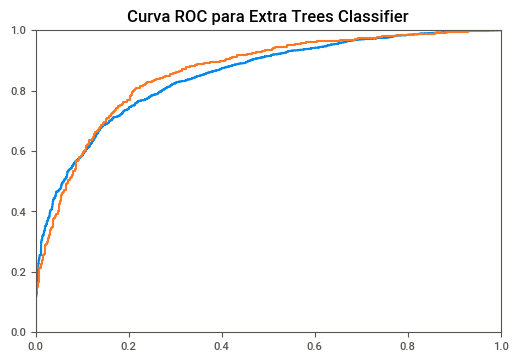

In [ ]:
'''pipeline_Ex_tree.set_params(**otimizacao_tree.best_params_).fit(X_train[features], y_train) # aplicando o melhores parametros do Randomized Search

report(y_test,X_test, pipeline_Ex_tree, "Test Dataset")
opt_df_test_pred_proba = pipeline_Ex_tree.predict_proba(X_test)[:,1]
fpr_opt_test, tpr_opt_test, _ = roc_curve(y_test, opt_df_test_pred_proba, pos_label=1)
roc_opt_test = plt.plot(fpr_opt_test, tpr_opt_test, label = "Test Optimized Dataset")

report(df_oot[target],df_oot[features], pipeline_Ex_tree, "OOT Dataset")
opt_df_test_oot_proba = pipeline_Ex_tree.predict_proba(df_oot[features])[:,1]
fpr_oot_test, tpr_oot_test, _ = roc_curve(df_oot[target], opt_df_test_oot_proba, pos_label=1)
roc_opt_oot = plt.plot(fpr_oot_test, tpr_oot_test, label = "OOT Optimized Dataset")

print("ROC AUC SCORE:")
roc_auc_score_test = roc_auc_score(y_test,opt_df_test_pred_proba ).round(2)
roc_auc_score_oot = roc_auc_score(df_oot[target],opt_df_test_oot_proba ).round(2)
print(f'Optimized AUC SCORE Test Dataset: {roc_auc_score_test}')
print(f'Optimized AUC SCORE OOT Dataset: {roc_auc_score_oot}')

# Curva ROC com o Dataset de Teste e OOT
plt.title(label="Curva ROC para Extra Trees Classifier")
plt.xlim(0,1)
plt.ylim(0,1)
'''

### Regressão Logistica

In [ ]:
'''grid_logi_regre = {     "alg__penalty" : ['l1', 'l2', 'elasticnet'],
                        "alg__C" : np.logspace(-4, 50, 100)}

otimizacao_regression = RandomizedSearchCV(     estimator=pipeline_log_regr, param_distributions=grid_logi_regre, 
                                                n_iter=3000, n_jobs=-1, cv = cv_split, 
                                                scoring='roc_auc', verbose=1,
                                                random_state=123)
otimizacao_regression.fit(X_train[features], y_train)
resultados_reg = pd.DataFrame(otimizacao_regression.cv_results_)
resultados_reg.sort_values(by='rank_test_score', ascending= True, inplace=True)
'''

/opt/anaconda3/envs/AutoMLPycarret/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 300 is smaller than n_iter=3000. Running 300 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 10 folds for each of 300 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 618 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 968 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 1418 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1968 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2618 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  3.1min finished


Test Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.63      0.71      0.67      1191
      Vendeu       0.86      0.81      0.83      2618

    accuracy                           0.78      3809
   macro avg       0.75      0.76      0.75      3809
weighted avg       0.79      0.78      0.78      3809

OOT Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.70      0.75      0.72       604
      Vendeu       0.87      0.83      0.85      1177

    accuracy                           0.81      1781
   macro avg       0.78      0.79      0.79      1781
weighted avg       0.81      0.81      0.81      1781

ROC AUC SCORE:
Optimized AUC SCORE Test Dataset: 0.8531
Optimized AUC SCORE OOT Dataset: 0.865


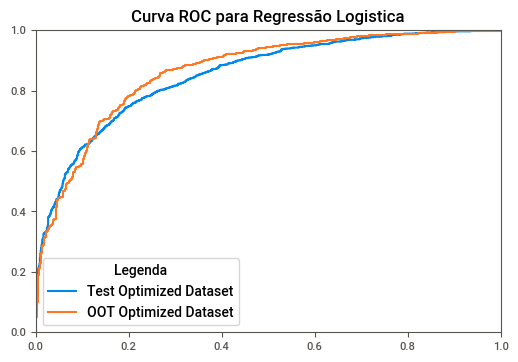

In [ ]:
'''pipeline_log_regr.set_params(**otimizacao_regression.best_params_).fit(X_train[features], y_train) # aplicando o melhores parametros do Randomized Search

report(y_test,X_test, pipeline_log_regr, "Test Dataset")
opt_df_test_pred_proba = pipeline_log_regr.predict_proba(X_test)[:,1]
fpr_opt_test, tpr_opt_test, _ = roc_curve(y_test, opt_df_test_pred_proba, pos_label=1)
roc_opt_test = plt.plot(fpr_opt_test, tpr_opt_test, label = "Test Optimized Dataset")

report(df_oot[target],df_oot[features], pipeline_log_regr, "OOT Dataset")
opt_df_test_oot_proba = pipeline_log_regr.predict_proba(df_oot[features])[:,1]
fpr_oot_test, tpr_oot_test, _ = roc_curve(df_oot[target], opt_df_test_oot_proba, pos_label=1)
roc_opt_oot = plt.plot(fpr_oot_test, tpr_oot_test, label = "OOT Optimized Dataset")

print("ROC AUC SCORE:")
auc_score_test_logit = roc_auc_score(y_test,opt_df_test_pred_proba ).round(2)
auc_score_oot_logit = roc_auc_score(df_oot[target],opt_df_test_oot_proba ).round(2)
print(f'Optimized AUC SCORE Test Dataset: {auc_score_test_logit}')
print(f'Optimized AUC SCORE OOT Dataset: {auc_score_oot_logit}')

# Curva ROC com o Dataset de Teste e OOT
plt.title(label="Curva ROC para Regressão Logistica")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(title = "Legenda") '''

### Gradient Boosting

In [156]:
'''
grid_gboost =   {   "alg__loss" : ["deviance", "exponential"],
                    "alg__learning_rate" : [0.01, 0.05, 0.06, 0.1, 0.15, 0.20],
                    "alg__min_samples_split" : [0.003, 0.005, 0.007, 0.01 ],
                    "alg__min_samples_leaf" : [10,20,50,70],
                    "alg__max_depth" : [3,5,8],
                    "alg__subsample" : [0.8]    
                }

otimizacao_gboost = RandomizedSearchCV(     estimator=pipeline_grad_boosting, param_distributions=grid_gboost, 
                                                n_iter=200, n_jobs=-1, cv = cv_split, 
                                                scoring='roc_auc', verbose=1,
                                                random_state=123)
#otimizacao_gboost.fit(X_train[features], y_train)
#resultados_gboost = pd.DataFrame(otimizacao_gboost.cv_results_)
#resultados_gboost.sort_values(by='rank_test_score', ascending= True, inplace=True)
'''


Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 25.9min finished


Test Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.78      0.70      0.74      1191
      Vendeu       0.87      0.91      0.89      2618

    accuracy                           0.85      3809
   macro avg       0.83      0.81      0.82      3809
weighted avg       0.84      0.85      0.84      3809

OOT Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.78      0.70      0.74       604
      Vendeu       0.85      0.90      0.87      1177

    accuracy                           0.83      1781
   macro avg       0.81      0.80      0.81      1781
weighted avg       0.83      0.83      0.83      1781

ROC AUC SCORE:
Optimized AUC SCORE Test Dataset: 0.9
Optimized AUC SCORE OOT Dataset: 0.88


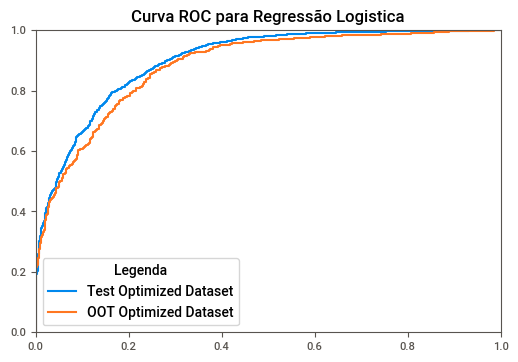

In [158]:
'''
pipeline_grad_boosting.set_params(**otimizacao_gboost.best_params_).fit(X_train[features], y_train) # aplicando o melhores parametros do Randomized Search

report(y_test,X_test, pipeline_grad_boosting, "Test Dataset")
opt_df_test_pred_proba = pipeline_grad_boosting.predict_proba(X_test)[:,1]
fpr_opt_test, tpr_opt_test, _ = roc_curve(y_test, opt_df_test_pred_proba, pos_label=1)
roc_opt_test = plt.plot(fpr_opt_test, tpr_opt_test, label = "Test Optimized Dataset")

report(df_oot[target],df_oot[features], pipeline_grad_boosting, "OOT Dataset")
opt_df_test_oot_proba = pipeline_grad_boosting.predict_proba(df_oot[features])[:,1]
fpr_oot_test, tpr_oot_test, _ = roc_curve(df_oot[target], opt_df_test_oot_proba, pos_label=1)
roc_opt_oot = plt.plot(fpr_oot_test, tpr_oot_test, label = "OOT Optimized Dataset")

print("ROC AUC SCORE:")
auc_score_test_logit = roc_auc_score(y_test,opt_df_test_pred_proba ).round(2)
auc_score_oot_logit = roc_auc_score(df_oot[target],opt_df_test_oot_proba ).round(2)
print(f'Optimized AUC SCORE Test Dataset: {auc_score_test_logit}')
print(f'Optimized AUC SCORE OOT Dataset: {auc_score_oot_logit}')
'''

In [349]:

n_estimators  = range(50,1551,100)
params_boosting = { 'alg__n_estimators' : n_estimators}

pipeline_grad_boosting = Pipeline([   ('prep' , preparation),
                                ('alg' , ensemble.GradientBoostingClassifier(learning_rate=0.25 ,min_samples_split=0.01, min_samples_leaf=50,max_depth=4, max_features='sqrt',subsample=0.8, random_state=10))])

gseatch1 = GridSearchCV(    estimator=pipeline_grad_boosting, param_grid= params_boosting, 
                            cv = cv_split, scoring="neg_log_loss", verbose=0 , n_jobs=-1)
gseatch1.fit(X_train[features], y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=123, test_size=None, train_size=None),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['idade_dias',
                                                                          'variedade_prod',
                                                                          'qtde_prod_vendidos',
                                                               

In [350]:
resultados_gboost = pd.DataFrame(gseatch1.cv_results_)

-0.408451 (0.010215) with: {'alg__n_estimators': 50}
-0.393852 (0.008809) with: {'alg__n_estimators': 150}
-0.385151 (0.009104) with: {'alg__n_estimators': 250}
-0.381211 (0.010601) with: {'alg__n_estimators': 350}
-0.373693 (0.011837) with: {'alg__n_estimators': 450}
-0.371564 (0.011949) with: {'alg__n_estimators': 550}
-0.370484 (0.013621) with: {'alg__n_estimators': 650}
-0.368705 (0.012568) with: {'alg__n_estimators': 750}
-0.369219 (0.013108) with: {'alg__n_estimators': 850}
-0.369058 (0.014109) with: {'alg__n_estimators': 950}
-0.370040 (0.011916) with: {'alg__n_estimators': 1050}
-0.371702 (0.011493) with: {'alg__n_estimators': 1150}
-0.373653 (0.012483) with: {'alg__n_estimators': 1250}
-0.375009 (0.012761) with: {'alg__n_estimators': 1350}
-0.377121 (0.013466) with: {'alg__n_estimators': 1450}
-0.379698 (0.012816) with: {'alg__n_estimators': 1550}


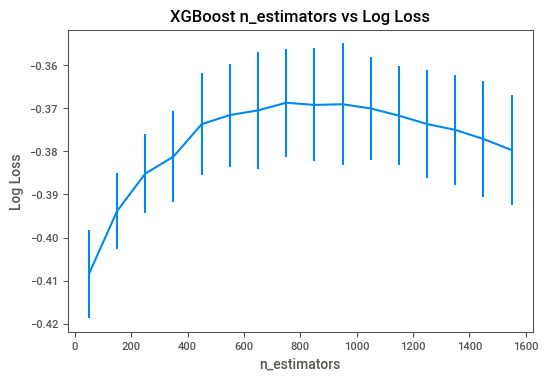

In [351]:
means = gseatch1.cv_results_['mean_test_score']
stds = gseatch1.cv_results_['std_test_score']
params = gseatch1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(n_estimators, means, yerr=stds)
plt.title("XGBoost n_estimators vs Log Loss")
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('n_estimators.png')

### Light Gradient Boosting

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.2min finished


Test Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.77      0.82      0.79      1187
      Vendeu       0.92      0.89      0.90      2613

    accuracy                           0.86      3800
   macro avg       0.84      0.85      0.85      3800
weighted avg       0.87      0.86      0.87      3800

OOT Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.77      0.74      0.76       604
      Vendeu       0.87      0.89      0.88      1177

    accuracy                           0.84      1781
   macro avg       0.82      0.82      0.82      1781
weighted avg       0.84      0.84      0.84      1781

ROC AUC SCORE:
Optimized AUC SCORE Test Dataset: 0.93
Optimized AUC SCORE OOT Dataset: 0.89


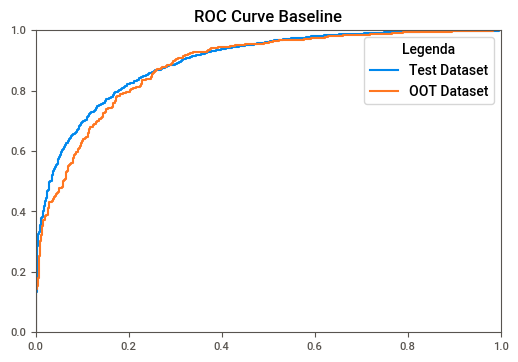

In [454]:

grid_lgbm = {   
                'alg__boosting_type' : ['gbdt'], # for better accuracy -> try dart
                'alg__colsample_bytree' : [0.65,0.75],
                'alg__learning_rate': [0.2],
                'alg__max_bin':[300], # large max_bin helps improve accuracy but might slow down training progress
                'alg__n_estimators': [500],
                'alg__num_leaves': [20], # large num_leaves helps improve accuracy but might lead to over-fitting
                'alg__objective' : ['binary'],
                'alg__reg_alpha' : [0.45,0.55, 0.65],
                'alg__reg_lambda' : [0.75, 0.85 , 1],
                'alg__subsample' : [0.65,0.75]
            }

#optm_lgbm = RandomizedSearchCV(     estimator=pipe_lgbm, param_distributions=grid_lgbm, 
#                                    n_iter=300, n_jobs=-1, cv = cv_split, 
#                                    scoring='roc_auc', verbose=1,
#                                    random_state=123)

grid_sc_lgbm =GridSearchCV(estimator=pipe_lgbm, param_grid=grid_lgbm, n_jobs=-1, cv=cv_split, scoring='roc_auc', verbose=1 , return_train_score=True)

grid_sc_lgbm.fit(X_train[features], y_train)

resultados_lgbm_refino = pd.DataFrame(grid_sc_lgbm.cv_results_)
resultados_lgbm_refino.sort_values(by='rank_test_score', ascending= True, inplace=True)


pipe_lgbm.set_params(**grid_sc_lgbm.best_params_).fit(X_train[features], y_train) # aplicando o melhores parametros do Grid Search

report(y_test,X_test, pipe_lgbm, "Test Dataset")
y_test_proba = pipe_lgbm.predict_proba(X_test)[:,1]

report(df_oot[target],df_oot[features], pipe_lgbm, "OOT Dataset")
y_oot_proba = pipe_lgbm.predict_proba(df_oot[features])[:,1]


print("ROC AUC SCORE:")
auc_score_test_lgbm = roc_auc_score(y_test,y_test_proba ).round(2)
auc_score_oot_lgbm = roc_auc_score(df_oot[target],y_oot_proba ).round(2)
print(f'Optimized AUC SCORE Test Dataset: {auc_score_test_lgbm}')
print(f'Optimized AUC SCORE OOT Dataset: {auc_score_oot_lgbm}')

#Curva ROC com o Dataset de Teste e OOT
roc_test_df = plt.plot(fpr_test, tpr_test, label = "Test Dataset")
roc_oot_df = plt.plot(fpr_oot, tpr_oot, label = "OOT Dataset")
plt.title(label="ROC Curve Otimizado")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(title = "Legenda")


In [399]:
grid_sc_lgbm.best_params_

{'alg__boosting_type': 'gbdt',
 'alg__colsample_bytree': 0.65,
 'alg__learning_rate': 0.2,
 'alg__max_bin': 300,
 'alg__n_estimators': 300,
 'alg__num_leaves': 20,
 'alg__objective': 'binary',
 'alg__reg_alpha': 0.55,
 'alg__reg_lambda': 1,
 'alg__subsample': 0.65}

In [380]:
pipe_lgbm

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['idade_dias',
                                                   'variedade_prod',
                                                   'qtde_prod_vendidos',
                                                   'media_prod_vend_order',
                                                   'media_fotos',
                                                   'media_letras_desc',
                                                   'avaliacao_safra',
                                                   'delta_avaliacao_idade_base',

## Análise dos resultados

Com os Resultados obtidos nos Algoritmos e com base nas probabilidades da variável ser 1 ou 0 plotei apenas para ter uma ideia de como estaria a Distribuição dos dados 

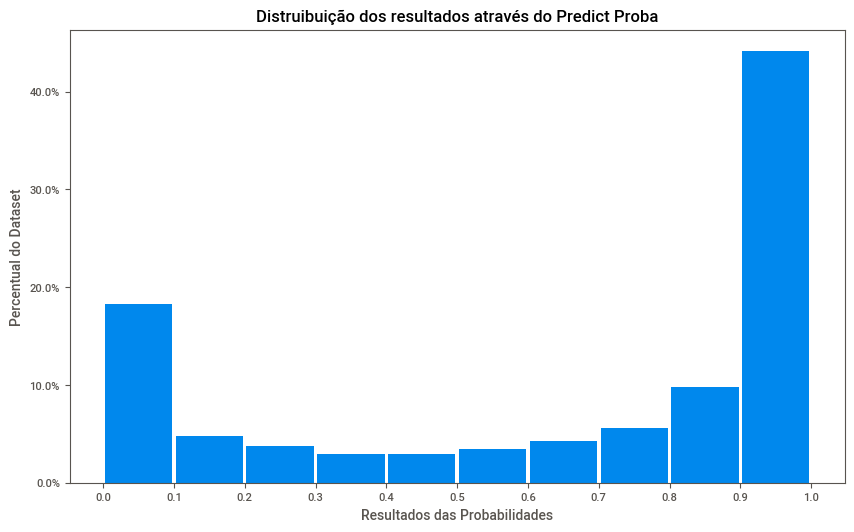

In [470]:
import math
from matplotlib.ticker import PercentFormatter
scores = y_oot_proba.tolist()
classes = []
for x in scores:
    num =( (int)(math.floor( math.fabs( x ) * 10 ) ) ) % 10
    classes.append(num)

groups = np.arange(0, 1.01, step=0.1)

plt.subplots(figsize = (10, 6))
plt.xticks(groups)
plt.hist(x=scores, bins = groups, rwidth=0.95, weights=np.ones(len(scores)) / len(scores))
plt.ylabel("Percentual do Dataset")
plt.xlabel("Resultados das Probabilidades")
plt.title("Distruibuição dos resultados através do Predict Proba")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

## Salvando um Pickle com as informaçoes relavantes

In [459]:
# Preparando para o arquivo Pickle

pick = {    "cols_num" : num_features,
            "cat_features" : cat_features,
            "features" : features,
            "target" : target,
            "cv_split" : ShuffleSplit(n_splits=10),
            "grid_parametres" : grid_lgbm,
            "pipeline_algoritmo" : grid_sc_lgbm.best_estimator_,
            "roc_auc_score_test" : auc_score_test_lgbm,
            "roc_auc_score_oot" : auc_score_oot_lgbm}

historical = pd.Series(pick)
print("Arquivo Pickle Criado")
historical.to_pickle(os.path.join(dir_project, 'Modelling/modelo_otimizado.pkl'))

Arquivo Pickle Criado
